In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sentinelhub import WebFeatureService, BBox, CRS, DataSource, WcsRequest, MimeType

## Utility functions

In [7]:
def plot_image(image, factor=1):
    """
    Utility function for plotting RGB images.
    """
    fig = plt.subplots(nrows=1, ncols=1, figsize=(15, 7))

    if np.issubdtype(image.dtype, np.floating):
        plt.imshow(np.minimum(image * factor, 1))
    else:
        plt.imshow(image)

## Configuration

In [8]:
# lowerleft, upper right
# Bounding box for area of interest
AOI = [-97.1254, 40.5755, -96.9578, 40.7007] 
YEAR = 2017
DATA_FOLDER = './data/raw/' + str(YEAR)

INSTANCE_ID = '29ce4ad4-0be2-42db-ac61-144fbc856641'
LAYER = 'BANDS-S2-L1C' # fetching all spectral bands

## Fetching and saving all Sentinel-2’s raw band values for AOI

In [11]:
AOI_bbox = BBox(bbox=AOI, crs=CRS.WGS84)

wms_bands_request = WcsRequest(layer=LAYER,
                               bbox=AOI_bbox,
                               time=('2017-04-01', '2017-08-31'),
                               maxcc=0.1,
                               resx='10m', resy='10m',
                               image_format=MimeType.TIFF_d32f,
                               instance_id=INSTANCE_ID, 
                               data_folder=DATA_FOLDER)

wms_bands_img = wms_bands_request.get_data(save_data=True)

## Image and Date information

In [12]:
print('These %d images were taken on the following dates:' % len(wms_bands_img))
for index, date in enumerate(wms_bands_request.get_dates()):
    print(' - image %d was taken on %s' % (index, date))

These 5 images were taken on the following dates:
 - image 0 was taken on 2017-05-13 17:22:57
 - image 1 was taken on 2017-06-02 17:22:56
 - image 2 was taken on 2017-06-09 17:20:15
 - image 3 was taken on 2017-07-19 17:20:46
 - image 4 was taken on 2017-08-23 17:20:56


## Filter images with missing data

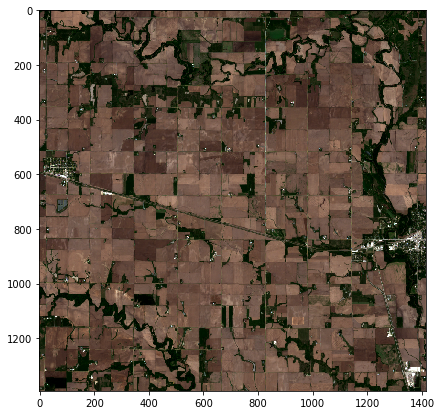

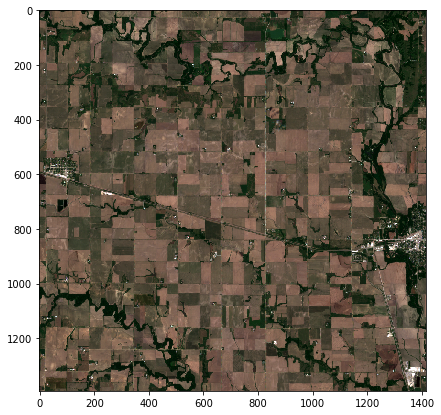

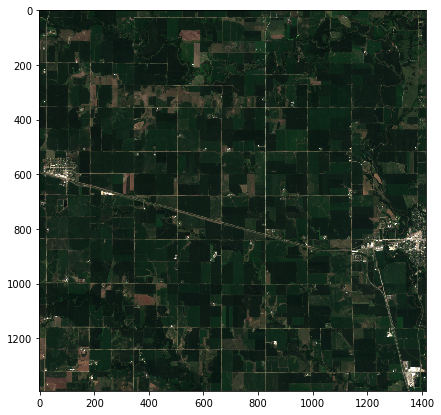

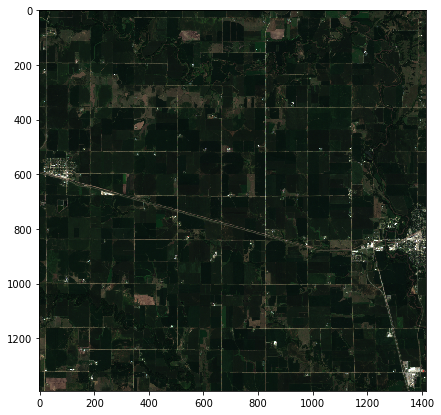

In [13]:
for i in range(len(wms_bands_img)):
    non_missing_data = np.count_nonzero(wms_bands_img[i][:, :, -1]) / wms_bands_img[i][:, :, -1].size
    
    if non_missing_data == 1.0:
        plot_image(wms_bands_img[i][:, :, [3, 2, 1]], 2.5)

## Loading geotiff to numpy array

In [14]:
import gdal
import osgeo.gdalnumeric as gdn

def img_to_array(input_file, dim_ordering="channels_last", dtype='float32'):
    file  = gdal.Open(input_file)
    bands = [file.GetRasterBand(i) for i in range(1, file.RasterCount + 1)]
    arr = np.array([gdn.BandReadAsArray(band) for band in bands]).astype(dtype)
    if dim_ordering=="channels_last":
        arr = np.transpose(arr, [1, 2, 0])  # Reorders dimensions, so that channels are last
    return arr